<a href="https://colab.research.google.com/github/denisded/ColabProject/blob/main/%22%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA%D1%83%D1%80%D1%81%D0%B0_USD_RUB%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# День 2
Предсказание курса доллара

Данные от центробанка: http://cbr.ru/currency_base/dynamics/

Данные по нефти: https://www.eia.gov/dnav/pet/hist/rbrteD.htm

In [9]:
import pandas as pd

In [10]:
usd_rate = pd.read_excel("/content/RC_F01_08_2014_T13_01_2021.xlsx")

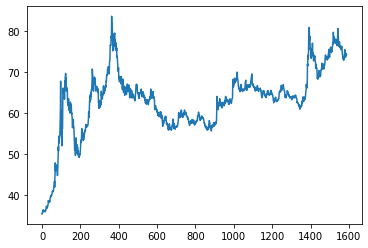

In [11]:
usd_rate["curs"].plot()

In [12]:
brent_oil = pd.read_excel("/content/brent_oil.xls", sheet_name=1, skiprows=2, names=["date", "oil_price"])

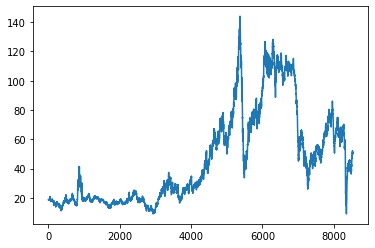

In [13]:
brent_oil["oil_price"].plot()

In [14]:
df = usd_rate.set_index('data').join(brent_oil.set_index("date")) # Объединим две таблица на основе дат

In [15]:
df.drop(["nominal", "cdx"], inplace=True, axis=1) # Удаляем лишние колонки

In [16]:
df.fillna(method='ffill', inplace=True) # Заполняем пустые ячейки

In [17]:
df.reset_index(inplace=True) # "Сбрасываем индекс"

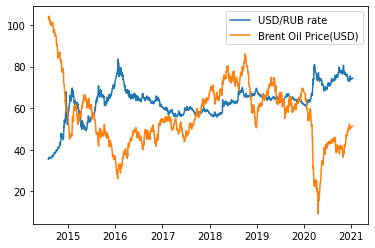

In [18]:
import matplotlib.pyplot as plt

plt.plot(df["data"],df["curs"], label="USD/RUB rate")
plt.plot(df["data"],df["oil_price"], label="Brent Oil Price(USD)")
plt.legend()

In [19]:
df
# Добавим колонки
# Цены на нефть за прошлые 7 дней
# Цены на доллар за прошлые 7 дней
# Год, месяц, день недели

,data,curs,oil_price
0,2014-08-01,35.4438,103.45
1,2014-08-02,35.7272,103.45
2,2014-08-05,35.6605,102.82
3,2014-08-06,35.7987,104.17
4,2014-08-07,36.1102,104.02
...,...,...,...
1583,2020-12-30,73.6567,50.74
1584,2020-12-31,73.8757,51.22
1585,2021-01-01,73.8757,51.22
1586,2021-01-12,74.5157,51.22


In [20]:
df["year"] = df["data"].dt.year # Создаем колонку год из поля "data"
df["month"] = df["data"].dt.month
df["weekday"] = df["data"].dt.weekday

In [21]:
df.groupby("year")["curs"].mean() # Как посмотреть средний курс по годами

year
2014    43.304247
2015    61.319435
2016    66.833472
2017    58.298185
2018    62.926389
2019    64.618432
2020    72.323002
2021    74.219233
Name: curs, dtype: float64

In [22]:
past_days = 7

for day in range(past_days):
  d = day+1
  df[f"usd_lag_{d}"] = df["curs"].shift(d) # Создаем колонку usd_lag_*, и записываем в нее курс доллара со сдвигом
  df[f"oil_lag_{d}"] =  df["oil_price"].shift(d) # Цена на нефть со сдвигом

In [23]:
df["usd_week"] = df["curs"].shift(1).rolling(window=7).median()
df["oil_week"] = df["oil_price"].shift(1).rolling(window=7).median()

In [24]:
# Подготовка к обучению
final_df = pd.get_dummies(df, columns = ["year", "month", "weekday"]) # Преобразуем колонки
final_df.drop(["data", "oil_price"], axis=1, inplace=True) # Выкидываем лишние колонки
final_df.dropna(inplace=True) # Выкидываем лишние строчки
final_df

,curs,usd_lag_1,oil_lag_1,usd_lag_2,oil_lag_2,usd_lag_3,oil_lag_3,usd_lag_4,oil_lag_4,usd_lag_5,oil_lag_5,usd_lag_6,oil_lag_6,usd_lag_7,oil_lag_7,usd_week,oil_week,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
7,36.0475,36.4461,103.36,36.2496,103.36,36.1102,104.02,35.7987,104.17,35.6605,102.82,35.7272,103.45,35.4438,103.45,35.7987,103.45,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
8,36.0890,36.0475,101.68,36.4461,103.36,36.2496,103.36,36.1102,104.02,35.7987,104.17,35.6605,102.82,35.7272,103.45,36.0475,103.36,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
9,36.2222,36.0890,102.27,36.0475,101.68,36.4461,103.36,36.2496,103.36,36.1102,104.02,35.7987,104.17,35.6605,102.82,36.0890,103.36,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
10,36.0395,36.2222,101.15,36.0890,102.27,36.0475,101.68,36.4461,103.36,36.2496,103.36,36.1102,104.02,35.7987,104.17,36.1102,103.36,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
11,36.0014,36.0395,101.13,36.2222,101.15,36.0890,102.27,36.0475,101.68,36.4461,103.36,36.2496,103.36,36.1102,104.02,36.1102,102.27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,73.6567,73.7175,50.44,73.6921,50.88,74.8392,50.88,75.4571,50.88,75.3498,51.05,74.6721,49.88,73.3155,52.17,74.6721,50.88,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1584,73.8757,73.6567,50.74,73.7175,50.44,73.6921,50.88,74.8392,50.88,75.4571,50.88,75.3498,51.05,74.6721,49.88,74.6721,50.88,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1585,73.8757,73.8757,51.22,73.6567,50.74,73.7175,50.44,73.6921,50.88,74.8392,50.88,75.4571,50.88,75.3498,51.05,73.8757,50.88,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1586,74.5157,73.8757,51.22,73.8757,51.22,73.6567,50.74,73.7175,50.44,73.6921,50.88,74.8392,50.88,75.4571,50.88,73.8757,50.88,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [25]:
# Делим данные
X = final_df.drop("curs", axis=1) # Берем все кроме колонки "курс доллара", данные на основе которых делаем прогноз

In [26]:
y = final_df["curs"] # То, что пытаемся предсказать

In [27]:
# 1. Обучить модель
# "Учебник" — тренировочная выборка (обучающая выборка) train set

# 2. Проверить хорошо ли она обучилась?
# "Экзамен" — тестовая выборка (проверочная) test set



In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Разделим на тестовую и обучающую в соотношении 30%/70%

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [30]:
model = LinearRegression() # Создаем модель, пока без настроек
model.fit(X_train, y_train) # Обучаем модель на тренировочной выборке
prediction = model.predict(X_test) # Используем модель для предсказания на тестовой выборке
mae = mean_absolute_error(y_test, prediction) # Считаем среднюю абсолютную ошибку
print(f"MAE = {mae}")

MAE = 0.5281679745855574


In [31]:
pd.DataFrame(data=[model.coef_], columns=X.columns).T # Выводим коэф. у параметров

,0
usd_lag_1,0.929461
oil_lag_1,-0.077571
usd_lag_2,0.015734
oil_lag_2,-0.039722
usd_lag_3,0.149010
oil_lag_3,0.154045
usd_lag_4,-0.084601
oil_lag_4,0.022923
usd_lag_5,-0.001677
oil_lag_5,0.042320


In [32]:
D1 = 75
D2 = 69
D3 = 90

MEAN = (D1+D2+D3) / 3

In [33]:
# USD = MEAN * 3 - D2 - D3 ==== D1

In [34]:
MEAN * 3 - D2 - D3 == D1

True

In [35]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

MAE = 0.5469302387184501


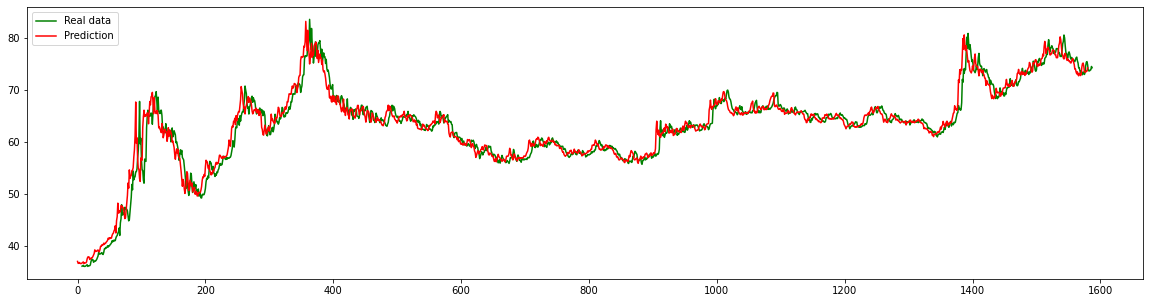

In [36]:
model = Lasso() # Создаем модель, пока без настроек
model.fit(X_train, y_train) # Обучаем модель на тренировочной выборке
prediction = model.predict(X_test) # Используем модель для предсказания на тестовой выборке
mae = mean_absolute_error(y_test, prediction) # Считаем среднюю абсолютную ошибку
print(f"MAE = {mae}")

plt.figure(figsize=(20,5)) # 
plt.plot(y, label="Real data", color="green")
plt.plot(model.predict(X), label="Prediction", color="red")
plt.legend()

In [37]:
model = RandomForestRegressor(n_estimators = 30) # Создаем модель, пока без настроек
model.fit(X_train, y_train) # Обучаем модель на тренировочной выборке
prediction = model.predict(X_test) # Используем модель для предсказания на тестовой выборке
mae = mean_absolute_error(y_test, prediction) # Считаем среднюю абсолютную ошибку
print(f"MAE = {mae}")

MAE = 0.5894699320802006


In [38]:
from sklearn.neural_network import MLPRegressor

In [39]:
model = MLPRegressor(activation="identity", hidden_layer_sizes=(250,250,250,250), max_iter=2000, random_state=42) 
# activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
model.fit(X_train, y_train) # Обучаем модель на тренировочной выборке
prediction = model.predict(X_test) # Используем модель для предсказания на тестовой выборке
mae = mean_absolute_error(y_test, prediction) # Считаем среднюю абсолютную ошибку
print(f"MAE = {mae}")

MAE = 0.6002549172652725
